Attempting this combination with LeNet from 1998. http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf.

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Initializing the parameters

In [134]:
batch_size = 64
num_classes = 10
learning_rate= 0.01
num_epochs = 6

# creating the model

With reference from here:

![](https://www.researchgate.net/profile/Yiren-Zhou-6/publication/312170477/figure/fig1/AS:448817725218816@1484017892071/Structure-of-LeNet-5.png)

In [135]:
class LeNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5), padding=(0,0), stride=(1,1))
        self.cnn2 = nn.Conv2d(in_channels=6,out_channels=16, kernel_size=(5,5), padding=(0,0), stride=(1,1))
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), padding=(0,0), stride=(1,1))
        self.pool1 = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.relu(self.cnn1(x))
        out = self.pool1(out)
        out = self.relu(self.cnn2(out))
        out = self.pool1(out)
        out = self.relu(self.cnn3(out))
    
        out = out.reshape(out.shape[0], -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out
        

In [136]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [137]:
model = LeNet().to(device=device)

In [138]:
# checking the model

x = torch.randn(64,1,28,28)
x = F.pad(input=x, pad=(2,2,2,2,0,0,0,0), mode='constant', value=0) 
# padding that it can be acommodated in leCun model
print(x.shape)
y = model(x)
y.shape

torch.Size([64, 1, 32, 32])


torch.Size([64, 10])

In [139]:
df = pd.read_csv("../input/digit-recognizer/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
test_df = pd.read_csv("../input/digit-recognizer/test.csv")
len(test_df)

test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:

x = df.iloc[:,1:].values
x = x.reshape(x.shape[0],1,28,28)
y = df.iloc[:,0]
x[0].shape, y.shape, y.values

((1, 28, 28), (42000,), array([1, 0, 1, ..., 7, 6, 9]))

tensor(1)


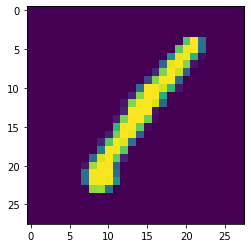

In [142]:
x_single = torch.tensor(x[0])
y_single = torch.tensor(y[0])
plt.imshow(x_single.permute(1,2,0))
print(y_single)

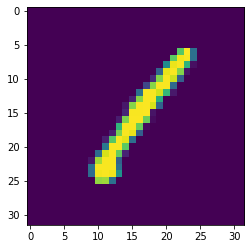

In [143]:
# lets apply padding

x_single = F.pad(input=x_single, pad=(2,2,2,2,0,0), mode='constant', value=0)
plt.imshow(x_single.permute(1,2,0))

In [144]:
class MNISTDataset(Dataset):
    def __init__(self, csvpath):
        df = pd.read_csv(csvpath)
        
        self.x = torch.tensor(df.iloc[:,1:].values)
        self.y = torch.tensor(df.iloc[:,0].values)
        
        self.x = self.x.float()
        self.y = self.y.float()
        
        self.n_samples = y.shape[0]
    
    def __getitem__(self, index):
        x = self.x[index]
        x = x.reshape(1,28,28)
        x = F.pad(input=x, pad=(2,2,2,2,0,0), mode='constant', value=0)
        
        return x, y[index]
    
    def __len__(self):
        return self.n_samples

In [145]:
class MNISTTestDataset(Dataset):
    def __init__(self, csvpath):
        df = pd.read_csv(csvpath)
        
        self.x = torch.tensor(df.iloc[:,:].values)
        self.x = self.x.float()
        
        self.n_samples = len(df)
    
    def __getitem__(self, index):
        x = self.x[index]
        x = x.reshape(1,28,28)
        x = F.pad(input=x, pad=(2,2,2,2,0,0), mode='constant', value=0)
        
        return x
    
    def __len__(self):
        return self.n_samples

In [146]:
train_dataset = MNISTDataset("../input/digit-recognizer/train.csv")
test_dataset = MNISTTestDataset("../input/digit-recognizer/test.csv")

In [157]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [158]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [159]:
for epoch in range(num_epochs):
    for data, target in train_dataloader:
        data = data.to(device=device)
        target = target.to(device=device)
        
        score = model(data)
        loss = loss_criterion(score, target)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    print(f"For epoch: {epoch}, loss: {loss}")

For epoch: 0, loss: 0.3789401650428772
For epoch: 1, loss: 0.17631612718105316
For epoch: 2, loss: 0.0033808224834501743
For epoch: 3, loss: 0.00018161181651521474
For epoch: 4, loss: 0.0027720804791897535
For epoch: 5, loss: 0.3749729096889496


In [160]:
def check_accuracy(model, loader):
    model.eval()
    
    correct_predict = 0
    total_predict = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            score = model(x)
            _, predictions = score.max(1)
            
            correct_predict += (predictions==y).sum()
            total_predict += predictions.size(0)
    
    print(f"Out of {total_predict} total correct: {correct_predict} with an accuracy of {(correct_predict/total_predict)*100}")
    

In [161]:
check_accuracy(model, train_dataloader)

Out of 42000 total correct: 40887 with an accuracy of 97.3499984741211


### Working on inference

In [162]:
y_preds = []
for x in test_dataloader:
    score = model(x)
    _, prediction = score.max(1)
    y_preds.append(prediction)
len(y_preds)

28000

In [163]:
submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [164]:
submission.iloc[100]['Label'], len(submission)

(0, 28000)

In [166]:
for i in range(len(submission)):
    submission.iloc[i]['Label'] = y_preds[i]

In [169]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [167]:
submission.to_csv('my_submission.csv')

In [168]:
pd.read_csv("./my_submission.csv").head()

,Unnamed: 0,ImageId,Label
0,0,1,2
1,1,2,0
2,2,3,9
3,3,4,0
4,4,5,3
